### Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Решение задачи

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#df = pd.read_csv('EDA_final_project1.csv')

#df = df.drop(['Unnamed: 0'], axis=1)

#при выгрузке датасета из предыдущего задания слетают все заполнители NaN-ов, поэтому приходится дублировать это:
#for k in ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
 #   df[k] = df[k].fillna('NA') # Not Applicableжщ9

In [2]:
phone = pd.read_csv('phone.csv')
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')

In [3]:
 phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [4]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Так как описание столбцов не было дано в задаче, сделаем это для облегчения понимания: 

###### phone
* customerID - код клиента
* BeginDate - подключено ли несколько телефонный линий одновременно

###### contract
* customerID - код клиента
* BeginDate - дата начала использования услуг компании
* EndDate - дата окончания использования услуг компании
* Type - тип оплаты: ежемесячно, раз в год или раз в два года
* PaperlessBilling - выставляется ли счет электронным методом (без использования бумаги)
* PaymentMethod - способ оплаты 
* MonthlyCharges - ежемесячный платёж (сумма)
* TotalCharges - сумма всех платежей

###### personal
* customerID - код клиента
* gender - пол клиента
* SeniorCitizen - является ли клиента пожилым (старше 60 лет)
* Partner - состоит ли клиент в браке
* Dependents - есть ли у клиента члены семьи на обеспечении (дети, нетрудоспособные люди)

###### internet
Про услуги уже было описано, они отмечены Yes или Not а зависимости от наличия подключения к каждой услуге, а в столбце InternetService указан тип подключения.

Всего заключены контракты с  7043 пользователями, из которых только интернетом пользуются 5517 пользователей, только телефоном - 6361 пользователь.

Какие проблемы в данных замечены?

1. Проверим как минимум customerID на дубликаты так как количество пользователей во всех источниках данных разное.

2. Приведем все столбцы к соответствующим типам, так как большинство объектов принадлежит типу odject, а некоторые данные соответсвуют другим типам. Об этом нужно сообщить коллегам которые выгружают данные, чтобы они сразу выгружались в правильных форматах.

3. Проверим на пропуски, аномалии, неизвестные значения (я еще не смотрела, но например, типа подключения объявлено всего два, а в значениях может появиться третий и т.п.).

In [11]:
print(phone['customerID'].duplicated().sum()),
print(contract['customerID'].duplicated().sum()),
print(personal['customerID'].duplicated().sum()),
print(internet['customerID'].duplicated().sum())

0
0
0
0


In [12]:
#создаем целевой признак на основе столбца EndDate: если Churn = 1, значит что клиент от нас ушел, иначе Churn = 0.
contract['Churn'] = 1
contract.loc[contract['EndDate'] == 'No', 'Churn'] = 0
contract['Churn'] = contract['Churn'].astype('bool')

#форматируем столбцы с датой
contract['EndDate1']= contract['EndDate'].replace('No', '2020-02-01')
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate']= pd.to_datetime(contract['EndDate'], format='%Y-%m-%dT%H:%M:%S',errors='coerce')

#у клиентов, которые с нами меньше месяса, столбец TotalCharges пуст. Заполним его суммой за месяц.
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

#вспомогательные столбцы для вычислений, ниже удалим
contract['begin_year'] = pd.DatetimeIndex(contract['BeginDate']).year
contract['end_year'] = pd.DatetimeIndex(contract['EndDate1']).year
contract['begin_month'] = pd.DatetimeIndex(contract['BeginDate']).month
contract['end_month'] = pd.DatetimeIndex(contract['EndDate1']).month

#добавляем признак Months: сколько полных месяцев клиент с нами
contract['Months'] = ((contract['end_year']- contract['begin_year']) * 12 + (contract['end_month'] - contract['begin_month']))

#добавляем признак Begin_Now_diff: сколько месяцев клиент был с нами на 1 февраля 2020 года
#contract['Begin_Now_diff'] =  ((2020- contract['begin_year']) * 12 + (2 - contract['begin_month']))

contract = contract.drop(['begin_year','end_year','begin_month','end_month', 'EndDate1'], axis=1)

In [13]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Months
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,False,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,False,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,False,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True,2


In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             1869 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null bool
Months              7043 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 502.2+ KB


In [15]:
#Объединяем данные в один датафрейм
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')

#заполняем пропуски после объединения
for k in ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    data[k] = data[k].fillna('NA') # Not Applicable

#Создаем признак Services: сколько основных сервисов использует клиент
data['Services'] = 0 # person use All main services
data.loc[data['MultipleLines'] == 'NA', 'Services'] = 1 # person use only Internet service
data.loc[data['InternetService'] == 'NA', 'Services'] = 2 # person use only Phone service
data['EndDate'] = data['EndDate'].fillna('No')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null bool
Months              7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 n

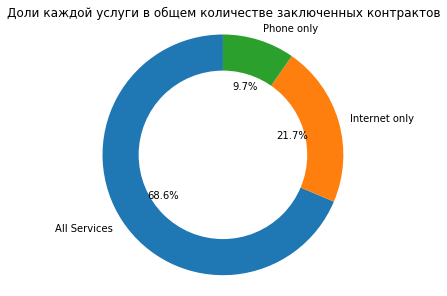

In [16]:
labels = ['All Services', 'Internet only', 'Phone only']
sizes = data['Services'].value_counts().values
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Доли каждой услуги в общем количестве заключенных контрактов")
plt.show()

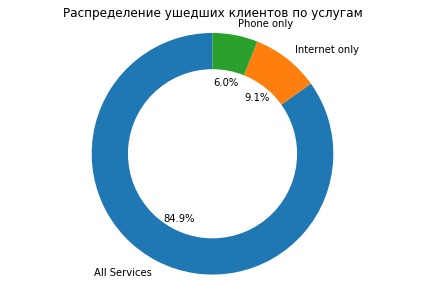

In [17]:
labels = ['All Services', 'Internet only', 'Phone only']
churn_data = data.query('Churn == 1')
sizes = churn_data['Services'].value_counts().values
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Распределение ушедших клиентов по услугам")
plt.show()

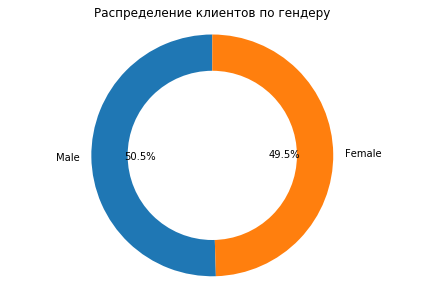

In [18]:
labels = ['Male', 'Female']
sizes = data['gender'].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Распределение клиентов по гендеру")
plt.show()
plt.show()

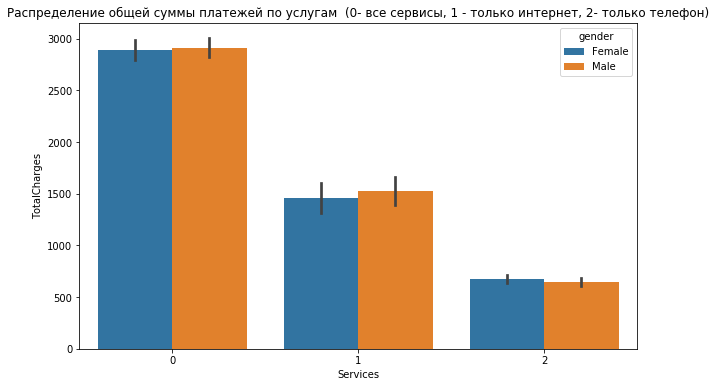

In [19]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Services", y="TotalCharges", hue="gender",  data=data)
plt.title("Распределение общей суммы платежей по услугам  (0- все сервисы, 1 - только интернет, 2- только телефон)")
plt.show()

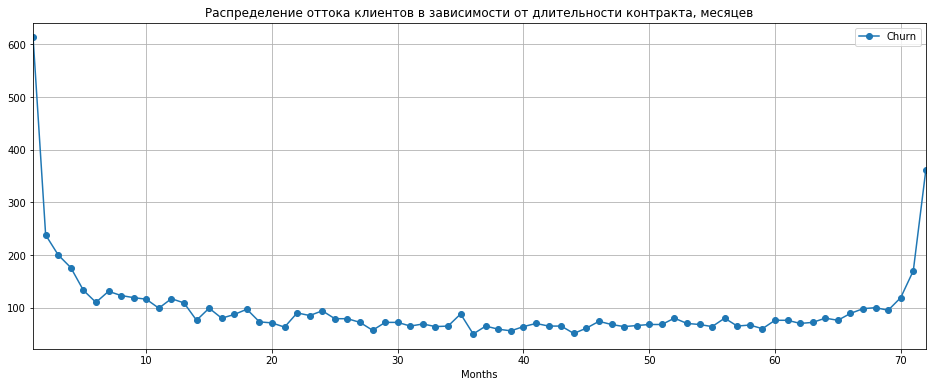

In [20]:
data.pivot_table(values = 'Churn', index ='Months', aggfunc='count').query('Months > 0').plot(style='o-', grid=True,figsize=(16, 6))
plt.title("Распределение оттока клиентов в зависимости от длительности контракта, месяцев")
plt.show()

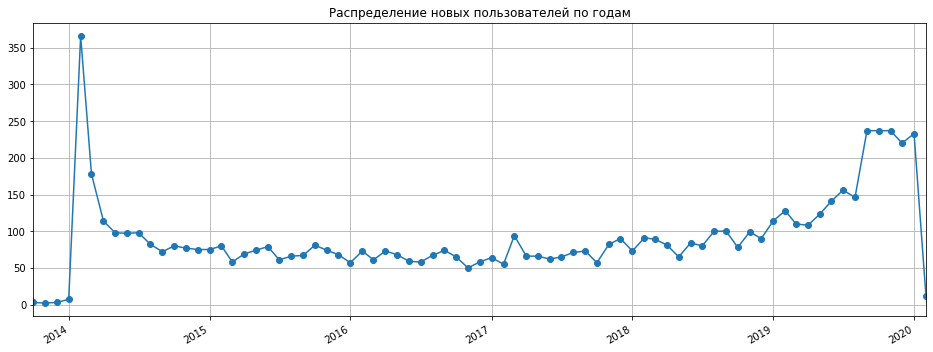

In [21]:
data['BeginDate'].value_counts().plot(style='o-', grid=True,figsize=(16, 6))
plt.title("Распределение новых пользователей по годам")
plt.show()

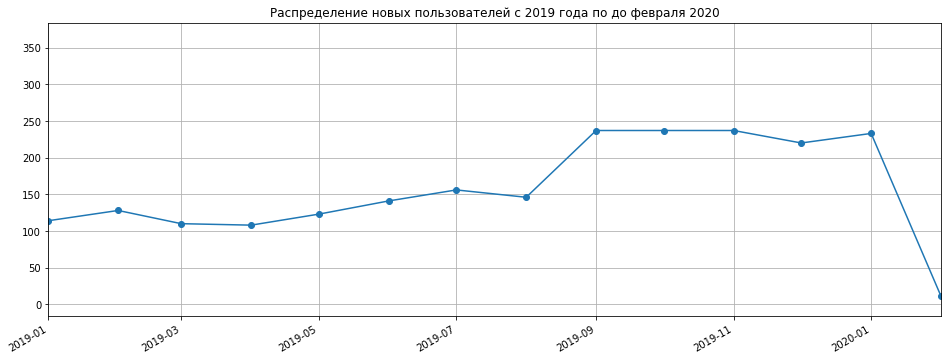

In [22]:
data['BeginDate'].value_counts().plot(style='o-',xlim = ('2019', '2020-02'), grid=True,figsize=(16, 6))
plt.title("Распределение новых пользователей с 2019 года по до февраля 2020")
plt.show()

#### Выводы
1. Данные были подготовлены (удалены пропуски, изменены типы), добавлены два новых признака - сколько месяцев ушедший клиент пользовался нашими услугами и целевой признак: ушел клиент от нас или нет.
2. 69% клиентов пользуются нашими обеими услугами, 10% пользуются только телефоном, 21% - только интернетом.
3. Из ушедших клиентов 85 % пользовались нашими обеими услугами, 6% - только телефоном, 9% - только интернетом. Это говорит о том, что проблема, на первый взгляд, заключена не в какой-либо конкретной нашей услуге, а в целом клиенты не хотят пользоваться нашими услугами.
4. Распределение по гендерам наших клиентов практически 50 на 50. Больше всего прибыли нам приносят клиенты, которые пользуются нашими обеими услугами, затем интернет, меньше всего прибыли от телефона. В целом, распределение платежей от клиентов в зависимости от гендера одинаковое с небольшим перевесом в сторону пользователей-мужчин. Кроме телефона - клиенты женского пола приносят чуть больше прибыли от телефонной связи чем мужчины.
5. Чаще всего от наших услуг отказываются наши новые клиенты - те, кто с нами меньше 10 месяцев.
6. Видно, что с 2018 года у нас пошел прирост пользователей (спасибо отделу маркетинга), и в период август- сентябрь 2019 у нас подключилось сразу много новых клиентов - на 90 человек больше, чем обычно. Но в период с января по февраль 2020 произошла какая-то катастрофа: мало того, что от нас отключаются пользователи, так и количество новых пользователей опустилось до уровня 2014 года, когда только открывалась наша компания.

In [23]:
df = data
#кодируем признаки
df = df.drop(['BeginDate', 'EndDate'], axis=1)

df_to_ohe = df.drop(['customerID', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Months'], axis=1)
df_no_ohe = df[['customerID', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Months']]
df_to_ohe = pd.get_dummies(df_to_ohe, drop_first=True)

df = df_no_ohe.join(df_to_ohe).drop(['customerID'], axis=1)

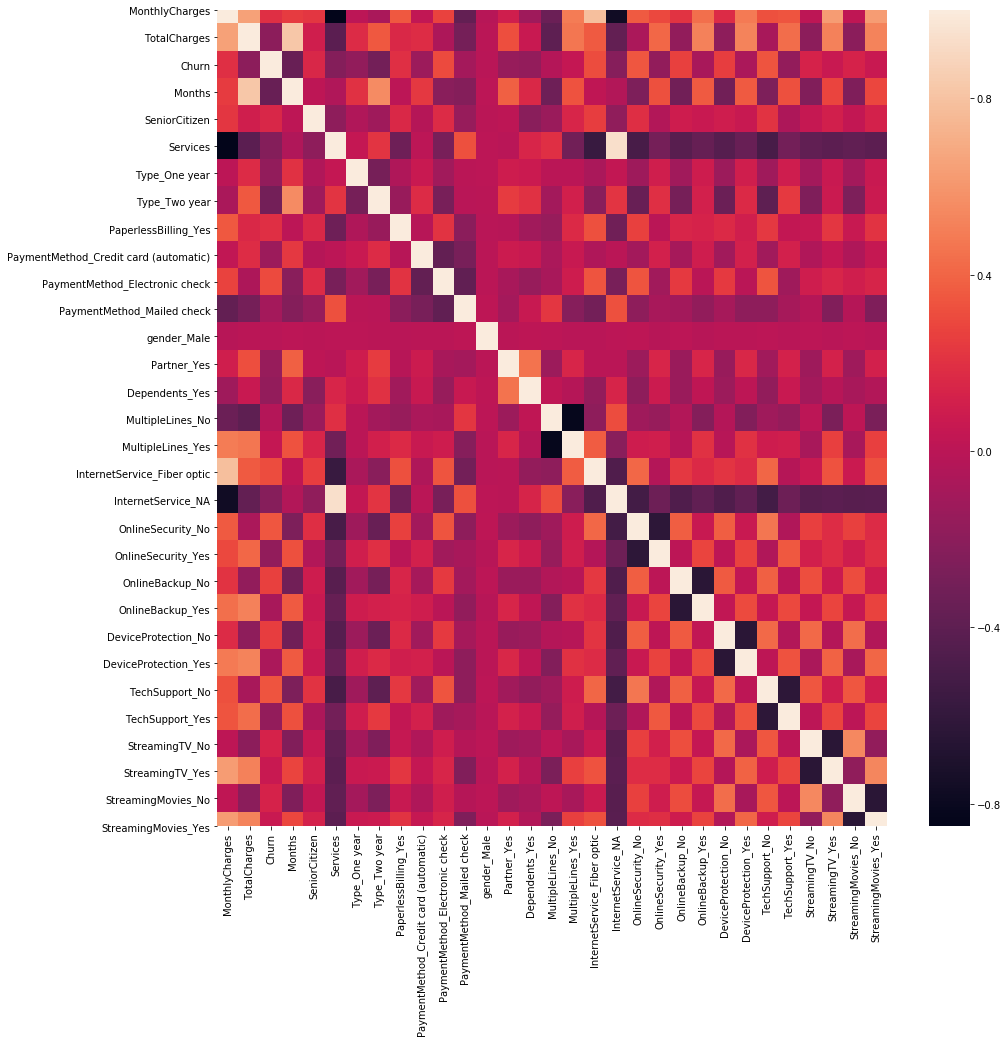

In [24]:
corrMatrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrMatrix, annot=False)

In [25]:
#разбиваем датасет
target = df['Churn']
features = df.drop('Churn', axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=2576)
features_train, features_valid, target_train, target_valid = train_test_split(
   features_other, target_other, test_size=0.25, random_state=2576)

print('features_train', len(features_train))
print('features_valid', len(features_valid))
print('features_test', len(features_test))

features_train 4225
features_valid 1409
features_test 1409


In [26]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train, target_train = upsample(features_train, target_train, 3)

In [27]:
%%time
#сюда будем записывать лучший результат на валидационной выборке по каждой модели
total_result = pd.DataFrame(columns = ['model', 'roc_auc_valid', 'recall_valid', 'precision_valid'])

#исследуем дерево
tree_result = pd.DataFrame()
i= 0

for depth in range(1, 21, 1):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    
    predictions_tree_train = model_tree.predict(features_train)
    predictions_tree_valid = model_tree.predict(features_valid)
    tree_result.loc[i, 'depth'] = depth
    tree_result.loc[i, 'f1_train'] = f1_score(target_train, predictions_tree_train)
    tree_result.loc[i, 'f1_valid'] = f1_score(target_valid, predictions_tree_valid)
    tree_result.loc[i, 'roc_auc_train'] = roc_auc_score(target_train, predictions_tree_train)
    tree_result.loc[i, 'roc_auc_valid'] = roc_auc_score(target_valid, predictions_tree_valid)
    tree_result.loc[i, 'recall_valid'] = recall_score(target_valid, predictions_tree_valid)
    tree_result.loc[i, 'precision_valid'] = precision_score(target_valid, predictions_tree_valid)
    i +=1
    

total_result.loc[0,'model'] = 'DecisionTreeClassifier'
total_result.loc[0,'roc_auc_valid'] = tree_result['roc_auc_valid'].max()

max_ = tree_result['roc_auc_valid'].max()
ind =  (tree_result.query('roc_auc_valid == @max_').index).values[0]

total_result.loc[0,'recall_valid'] = tree_result.loc[ind,'recall_valid']
total_result.loc[0,'precision_valid'] = tree_result.loc[ind,'precision_valid']

tree_result

Wall time: 1.23 s


,depth,f1_train,f1_valid,roc_auc_train,roc_auc_valid,recall_valid,precision_valid
0,1.0,0.712126,0.543796,0.683055,0.677842,0.752525,0.425714
1,2.0,0.615819,0.546479,0.684724,0.685719,0.489899,0.617834
2,3.0,0.745647,0.584521,0.732236,0.714792,0.724747,0.489761
3,4.0,0.756264,0.617989,0.748898,0.741836,0.737374,0.531876
4,5.0,0.779661,0.598309,0.767703,0.725536,0.714646,0.514545
5,6.0,0.799179,0.618106,0.785095,0.742720,0.750000,0.525664
6,7.0,0.819499,0.593952,0.806314,0.721358,0.694444,0.518868
7,8.0,0.850657,0.583593,0.835028,0.713633,0.709596,0.495591
8,9.0,0.873046,0.566120,0.863177,0.698689,0.654040,0.499037
9,10.0,0.903355,0.584885,0.893274,0.713725,0.674242,0.516441


In [28]:
%%time
#исследуем лес
forest_result = pd.DataFrame(columns = ['estim', 'depth', 'roc_auc_train', 'roc_auc_valid'])
i= 0
for estim in range(5, 51, 5):
    for depth in range(2, 11, 2):
        model_forest = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345, class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predictions_forest_train = model_forest.predict(features_train)
        predictions_forest_valid = model_forest.predict(features_valid)
 
        forest_result.loc[i, 'estim'] = estim
        forest_result.loc[i, 'depth'] = depth
        forest_result.loc[i, 'roc_auc_train'] = roc_auc_score(target_train, predictions_forest_train)
        forest_result.loc[i, 'roc_auc_valid'] = roc_auc_score(target_valid, predictions_forest_valid)
        forest_result.loc[i, 'recall_valid'] = recall_score(target_valid, predictions_forest_valid)
        forest_result.loc[i, 'precision_valid'] = precision_score(target_valid, predictions_forest_valid)
        i +=1
    
total_result.loc[1,'model'] = 'RandomForestClassifier'
total_result.loc[1,'roc_auc_valid'] = forest_result['roc_auc_valid'].max()

max_ = forest_result['roc_auc_valid'].max()
ind =  (forest_result.query('roc_auc_valid == @max_').index).values[0]
total_result.loc[1,'recall_valid'] = forest_result.loc[ind,'recall_valid']
total_result.loc[1,'precision_valid'] = forest_result.loc[ind,'precision_valid']

forest_result  

Wall time: 10.9 s


,estim,depth,roc_auc_train,roc_auc_valid,recall_valid,precision_valid
0,5.0,2.0,0.742079,0.726753,0.734848,0.505208
1,5.0,4.0,0.750918,0.731896,0.709596,0.530189
2,5.0,6.0,0.789667,0.769442,0.777778,0.560000
3,5.0,8.0,0.827894,0.766572,0.742424,0.581028
4,5.0,10.0,0.887868,0.729853,0.681818,0.545455
5,10.0,2.0,0.744496,0.735373,0.755051,0.509370
6,10.0,4.0,0.755437,0.739701,0.744949,0.523050
7,10.0,6.0,0.792584,0.769063,0.787879,0.552212
8,10.0,8.0,0.830635,0.753957,0.739899,0.554924
9,10.0,10.0,0.897513,0.744557,0.694444,0.569358


In [29]:
#исследуем логистическую регрессию
model_log = LogisticRegression(random_state=12345, class_weight='balanced')
model_log.fit(features_train, target_train)
predictions_log_train = model_log.predict(features_train)
predictions_log_valid = model_log.predict(features_valid)
roc_auc_log_train = roc_auc_score(target_train, predictions_log_train)
roc_auc_log_valid = roc_auc_score(target_valid, predictions_log_valid)
recall_log_valid = recall_score(target_valid, predictions_log_valid)
precision_log_valid = precision_score(target_valid, predictions_log_valid)
print('Качество логистической регрессии на обучающей выборке:', roc_auc_log_train )
print('Качество логистической регрессии на валидационной выборке:', roc_auc_log_valid )

total_result.loc[2,'model'] = 'LogisticRegression'
total_result.loc[2,'roc_auc_valid'] = roc_auc_log_valid
total_result.loc[2,'recall_valid'] = recall_log_valid
total_result.loc[2,'precision_valid'] = precision_log_valid

Качество логистической регрессии на обучающей выборке: 0.7638786035556665
Качество логистической регрессии на валидационной выборке: 0.7509497741481945


C:\Users\Tehnodent\DS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
#исследуем метод ближайших соседей
neigh_result = pd.DataFrame(columns = ['n_neighbors', 'roc_auc_train', 'roc_auc_valid'])
i= 0
for n in range(1, 20):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(features_train, target_train)
    prediction_neigh_train = neigh.predict(features_train)
    prediction_neigh_valid = neigh.predict(features_valid)
    neigh_result.loc[i, 'n_neighbors'] = n
    neigh_result.loc[i, 'roc_auc_train'] = roc_auc_score(target_train, prediction_neigh_train)
    neigh_result.loc[i, 'roc_auc_valid'] = roc_auc_score(target_valid, prediction_neigh_valid)
    neigh_result.loc[i, 'recall_valid'] = recall_score(target_valid, prediction_neigh_valid)
    neigh_result.loc[i, 'precision_valid'] = precision_score(target_valid, prediction_neigh_valid)
    i +=1    

total_result.loc[3,'model'] = 'KNeighborsClassifier'
total_result.loc[3,'roc_auc_valid'] = neigh_result['roc_auc_valid'].max()

max_ = neigh_result['roc_auc_valid'].max()
ind =  (neigh_result.query('roc_auc_valid == @max_').index).values[0]
total_result.loc[3,'recall_valid'] = neigh_result.loc[ind,'recall_valid']
total_result.loc[3,'precision_valid'] = neigh_result.loc[ind,'precision_valid']

neigh_result

,n_neighbors,roc_auc_train,roc_auc_valid,recall_valid,precision_valid
0,1.0,0.998602,0.65149,0.474747,0.519337
1,2.0,0.998602,0.65149,0.474747,0.519337
2,3.0,0.901052,0.677579,0.664141,0.456597
3,4.0,0.901052,0.677579,0.664141,0.456597
4,5.0,0.838432,0.674709,0.737374,0.426277
5,6.0,0.79699,0.694098,0.575758,0.545455
6,7.0,0.791393,0.694017,0.633838,0.502000
7,8.0,0.791393,0.694017,0.633838,0.502000
8,9.0,0.786493,0.701615,0.694444,0.482456
9,10.0,0.786652,0.701615,0.694444,0.482456


In [31]:
#формируем категориальные признаки
cat_features = [c for c, col in enumerate(features_train.columns) if col not in (df_no_ohe.columns)]

%%time
#подбираем гиперпараметры для LGBMClassifier

estimator = lgb.LGBMClassifier(class_weight='balanced', boosting_type = 'gbdt',
                        objective='binary', random_state=2576, reg_alpha = 0,
                        metric = 'auc', max_depth = 1, silent=True)

param_grid = {
    'learning_rate': [0.01, 0.1 ,0.5],
    'n_estimators': [2,10,60],
    'min_child_samples' : [10,50,100]
   
}

cv =KFold(random_state=2576, n_splits=7)
gbm = GridSearchCV(estimator, param_grid, cv=cv, scoring='roc_auc')

gbm.fit(features_train, target_train, categorical_feature=cat_features) #, eval_metric ='auc',eval_set =[(features_valid, target_valid)] )

print('Best parameters is:', gbm.best_params_)
print('Best score is:', gbm.best_score_)


In [32]:
#используем найденные гиперпараметры для обучения
model_lgb = lgb.LGBMClassifier(learning_rate=0.5, max_depth=1, n_estimators=60, min_child_samples = 10, class_weight='balanced',
                               reg_alpha = 0,objective='binary', metric = 'auc', random_state=2576)
model_lgb.fit(features_train, target_train, categorical_feature=cat_features)

probabilities_valid = model_lgb.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

lgb_score = roc_auc_score(target_valid, probabilities_one_valid)
recall_lgb_valid = recall_score(target_valid, probabilities_one_valid.round())
precision_lgb_valid = precision_score(target_valid, probabilities_one_valid.round())

total_result.loc[4,'model'] = 'LGBMClassifier'
total_result.loc[4,'roc_auc_valid'] = lgb_score
total_result.loc[4,'recall_valid'] = recall_lgb_valid
total_result.loc[4,'precision_valid'] = precision_lgb_valid

C:\Users\Tehnodent\DS\Anaconda\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [33]:
total_result

,model,roc_auc_valid,recall_valid,precision_valid
0,DecisionTreeClassifier,0.74272,0.75,0.525664
1,RandomForestClassifier,0.773115,0.775253,0.569573
2,LogisticRegression,0.75095,0.757576,0.536673
3,KNeighborsClassifier,0.730082,0.70202,0.531549
4,LGBMClassifier,0.849291,0.792929,0.548951


#подбираем гиперпараметры для CatBoostClassifier
model_cb_1 = CatBoostClassifier(eval_metric='AUC')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3]}

grid_search_result = model_cb_1.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,  plot=True)

Здесь может вылетать из-за проблем с памятью. Причем вылетает уже после окончания подбора гиперпараметров. Так или иначе, мы можем увидеть гиперпараметры с лучшим результатом.

In [34]:
#используем найденные гиперпараметры для обучения
model_cb_1 = CatBoostClassifier(depth = 10, learning_rate = 0.1, l2_leaf_reg = 1, eval_metric='AUC', random_state=2576)
model_cb_1.fit(features_train, target_train, verbose=100, plot=True)

probabilities_valid = model_cb_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


total_result.loc[5,'model'] = 'CatBoostClassifier_1'
total_result.loc[5,'roc_auc_valid'] = roc_auc_score(target_valid, probabilities_one_valid)
total_result.loc[5,'recall_valid'] = recall_score(target_valid, probabilities_one_valid.round())
total_result.loc[5,'precision_valid'] = precision_score(target_valid, probabilities_one_valid.round())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 105ms	remaining: 1m 45s
100:	total: 6.29s	remaining: 55.9s
200:	total: 12.2s	remaining: 48.6s
300:	total: 18.8s	remaining: 43.6s
400:	total: 24.5s	remaining: 36.6s
500:	total: 30.2s	remaining: 30.1s
600:	total: 36.6s	remaining: 24.3s
700:	total: 42.9s	remaining: 18.3s
800:	total: 49.3s	remaining: 12.3s
900:	total: 55.3s	remaining: 6.08s
999:	total: 1m 1s	remaining: 0us


In [35]:
#попробуем также без подобранных гиперпараметров, так как CatBoost в целом неплохо работает "из коробки"
model_cb_2 = CatBoostClassifier(eval_metric='AUC')
model_cb_2.fit(features_train, target_train, verbose=100, plot=True)

probabilities_valid = model_cb_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

total_result.loc[6,'model'] = 'CatBoostClassifier_2'
total_result.loc[6,'roc_auc_valid'] = roc_auc_score(target_valid, probabilities_one_valid)
total_result.loc[6,'recall_valid'] = recall_score(target_valid, probabilities_one_valid.round())
total_result.loc[6,'precision_valid'] = precision_score(target_valid, probabilities_one_valid.round())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.022759
0:	total: 8.67ms	remaining: 8.66s
100:	total: 962ms	remaining: 8.56s
200:	total: 2.04s	remaining: 8.09s
300:	total: 3.22s	remaining: 7.48s
400:	total: 4.16s	remaining: 6.21s
500:	total: 5.11s	remaining: 5.09s
600:	total: 6.05s	remaining: 4.02s
700:	total: 6.94s	remaining: 2.96s
800:	total: 8.55s	remaining: 2.12s
900:	total: 9.55s	remaining: 1.05s
999:	total: 10.6s	remaining: 0us


In [36]:
total_result.sort_values(by = 'roc_auc_valid', ascending = False)

,model,roc_auc_valid,recall_valid,precision_valid
4,LGBMClassifier,0.849291,0.792929,0.548951
6,CatBoostClassifier_2,0.834871,0.694444,0.568182
5,CatBoostClassifier_1,0.807226,0.542929,0.616046
1,RandomForestClassifier,0.773115,0.775253,0.569573
2,LogisticRegression,0.75095,0.757576,0.536673
0,DecisionTreeClassifier,0.74272,0.75,0.525664
3,KNeighborsClassifier,0.730082,0.70202,0.531549


Итак, наилучшими оказались 3 модели: LGBMClassifier, CatBoostClassifier_2 и CatBoostClassifier_1. Для них посчитаем метрику на тестовой выборке и выберем победителя. Дополнительно посмотрим на accuracy и матрицы ошибок.Примечательно, что CatBoostClassifier с дефолтными настройками показал себя чуть лучше чем тот, для которого гиперпараметры подбирались. Видимо, он хорошо работает самостоятельно, "из коробки".

Стоит прокомментировать также recall и precision. Значение recall у LGBMClassifier  самое высокое - эта модель лучше всего найдет положительные ответы, т.е. тех клиентов, которые уйдут. После нее идут случайный лес и логистическая регрессия. А вот точность у LGBMClassifier средняя - она не очень хорошо справляется с поиском отрицательных ответов. А вот модели CatBoostClassifier в точности вырываются вперед, когда в полноте были аутсайдерами.

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
test_result = pd.DataFrame(columns = ['model', 'roc_auc_test', 'accuracy_test'])

model_lgb.fit(features_train, target_train, categorical_feature=cat_features)
probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

test_result.loc[0,'model'] = 'LGBMClassifier'
test_result.loc[0,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)
test_result.loc[0,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())

confusion_matrix(target_test, probabilities_one_test.round())

C:\Users\Tehnodent\DS\Anaconda\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


array([[771, 252],
       [ 63, 323]], dtype=int64)

In [38]:
probabilities_test = model_cb_1.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

test_result.loc[1,'model'] = 'CatBoostClassifier_1'
test_result.loc[1,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)
test_result.loc[1,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())

confusion_matrix(target_test, probabilities_one_test.round())

array([[896, 127],
       [169, 217]], dtype=int64)

In [39]:
probabilities_test = model_cb_2.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

test_result.loc[2,'model'] = 'CatBoostClassifier_2'
test_result.loc[2,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)
test_result.loc[2,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())

confusion_matrix(target_test, probabilities_one_test.round())

array([[809, 214],
       [ 92, 294]], dtype=int64)

In [40]:
test_result.sort_values(by = 'roc_auc_test', ascending = False)

,model,roc_auc_test,accuracy_test
0,LGBMClassifier,0.880561,0.776437
2,CatBoostClassifier_2,0.862133,0.782825
1,CatBoostClassifier_1,0.8373,0.789922


Матрица ошибок у LGBMClassifier показывает, что эта модель - лидер по поиску истинноположительных ответов. Это говорит о том, что она с большей вероятностью по сравнению с остальными моделями найдет тех клиентов, которые собираются уйти. Этот вывод также подтверждается тем, что у модели самое маленькое количество ложноотрицательных ответов - модель реже других присваивает клиенту ложный статус Churn = 0.

Accuracy у LGBMClassifier хуже чем у представленных трех моделей, но в целом, значение неплохое и не сильно отрывается от остальных моделей.

### 1. Какие ключевые шаги в решении задачи выделили?

Одним из важнейших шагов могу назвать борьбу с дисбалансом и увеличение выборки. Также очень важно следить не только за ключевой метрикой, но и за такими метриками, как полнота и точность на каждой модели. Данные метрики в совокупности с матрицей ошибок способны указать на слабые стороны модели и понять, куда двигаться дальше. Третьим ключевым шагом могу отметить важность не только подбора значений гиперпараметров, но и определение какие из них оказывают наибольшее влияние на модель. Все вышеперечисленные шаги реализованы в моем проекте и помогли мне справиться с задачей.

 ### 2. Какая ваша итоговая модель и какое у неё качество?

Моей итоговой моделью является LGBMClassifier со следующими значениями метрик:

In [41]:
test_result.head(1)

,model,roc_auc_test,accuracy_test
0,LGBMClassifier,0.880561,0.776437
